# Import das bibliotecas

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import pymysql
import seaborn as sns
import numpy as np
from matplotlib.dates import DateFormatter
from scipy import stats

# Estilização do Seaborn

In [19]:
sns.set(style="whitegrid")


# Conexão com o Bando de Dados

In [20]:
def connect_to_db(host, port, user, password, db_name):
    conn = pymysql.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=db_name
    )
    return conn

host = 'localhost'  
port = 3306  
user = 'root'  
password = 'hanglose1'  
db_name = 'Docentify'  

conn = connect_to_db(host, port, user, password, db_name)

# Query para carregar os dados

In [21]:
query = """
SELECT 
    U.name AS Nome, 
    C.name AS Curso, 
    E.enrollmentDate AS Data_Inscricao, 
    UP.progressDate AS Data_Progresso, 
    S.title AS Etapa,
    S.description AS Descricao_Etapa,
    C.isRequired AS Curso_Obrigatorio,
    E.isActive AS Inscricao_Ativa
FROM Users U
JOIN Enrollments E ON U.id = E.userId
JOIN Courses C ON E.courseId = C.id
JOIN UserProgress UP ON E.id = UP.enrollmentId
JOIN Steps S ON UP.stepId = S.id
ORDER BY U.name, C.name, UP.progressDate;
"""

df_progress = pd.read_sql(query, conn)


/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_53425/270807636.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_progress = pd.read_sql(query, conn)


# Tratamento de dados

In [22]:

# Garante que todos os usuários estejam no gráfico, mesmo se não houver progresso
todos_os_usuarios = df_progress['Nome'].unique()

# 1. Agrupa e soma o progresso ao longo do tempo
df_progress_grouped = df_progress.groupby(['Data_Progresso', 'Nome']).size().reset_index(name='Total_Progresso')

# 2. Remove outliers usando o método IQR
Q1 = df_progress_grouped['Total_Progresso'].quantile(0.25)
Q3 = df_progress_grouped['Total_Progresso'].quantile(0.75)
IQR = Q3 - Q1
filter_outliers = ~((df_progress_grouped['Total_Progresso'] < (Q1 - 1.5 * IQR)) | (df_progress_grouped['Total_Progresso'] > (Q3 + 1.5 * IQR)))
df_progress_grouped = df_progress_grouped[filter_outliers]

# 3. Garantir que todos os usuários estejam representados na tabela, preenchendo progresso ausente com 0
df_progress_grouped_pivot = df_progress_grouped.pivot_table(index='Data_Progresso', columns='Nome', values='Total_Progresso').reindex(columns=todos_os_usuarios, fill_value=0).reset_index()

# 4. Transformação para formato longo (long format)
df_progress_long = df_progress_grouped_pivot.melt(id_vars=['Data_Progresso'], var_name='Nome', value_name='Progresso_Acumulado')

# 5. Standardização (usando Z-score)
df_progress_long['Progresso_Acumulado_Standard'] = stats.zscore(df_progress_long['Progresso_Acumulado'])

# 6. Verificação final de valores ausentes e tratamento adicional, se necessário
df_progress_long.fillna(0, inplace=True)

# SQL para contar quantos usuários estão inscritos em cada curso

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/391745255.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_courses = pd.read_sql(query_courses, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/391745255.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Inscritos', y='Curso', data=df_courses, palette='coolwarm')


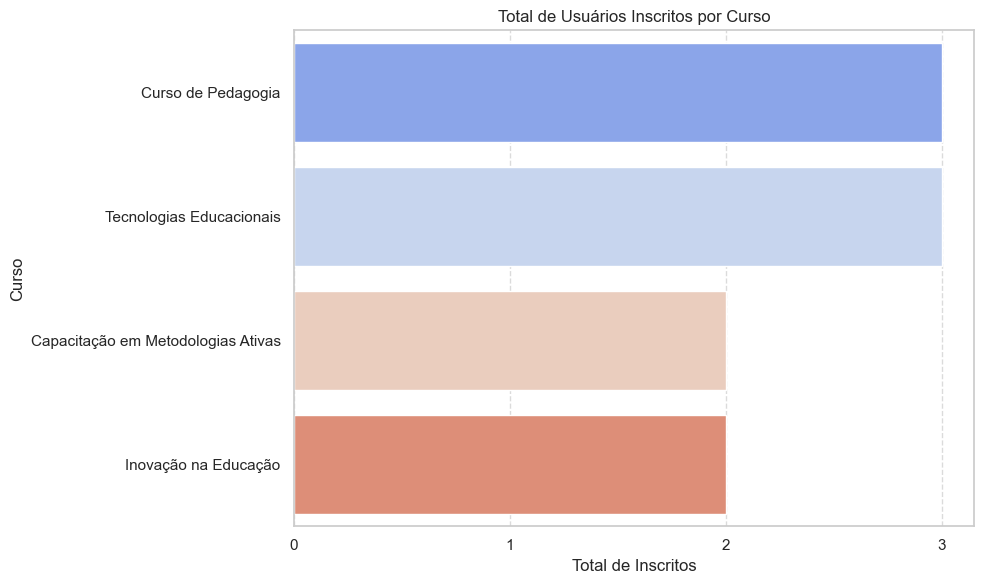

In [6]:
query_courses = """
SELECT 
    c.name AS Curso, 
    COUNT(e.userId) AS Total_Inscritos
FROM Enrollments e
JOIN Courses c ON e.courseId = c.id
WHERE e.isActive = 1  -- Considera apenas inscrições ativas
GROUP BY c.name
ORDER BY Total_Inscritos DESC;
"""

df_courses = pd.read_sql(query_courses, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Inscritos', y='Curso', data=df_courses, palette='coolwarm')
plt.xticks(ticks=range(0, df_courses['Total_Inscritos'].max() + 1, 1))
plt.title('Total de Usuários Inscritos por Curso')
plt.xlabel('Total de Inscritos')
plt.ylabel('Curso')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Progresso Acumulado dos Usuários ao Longo do Tempo

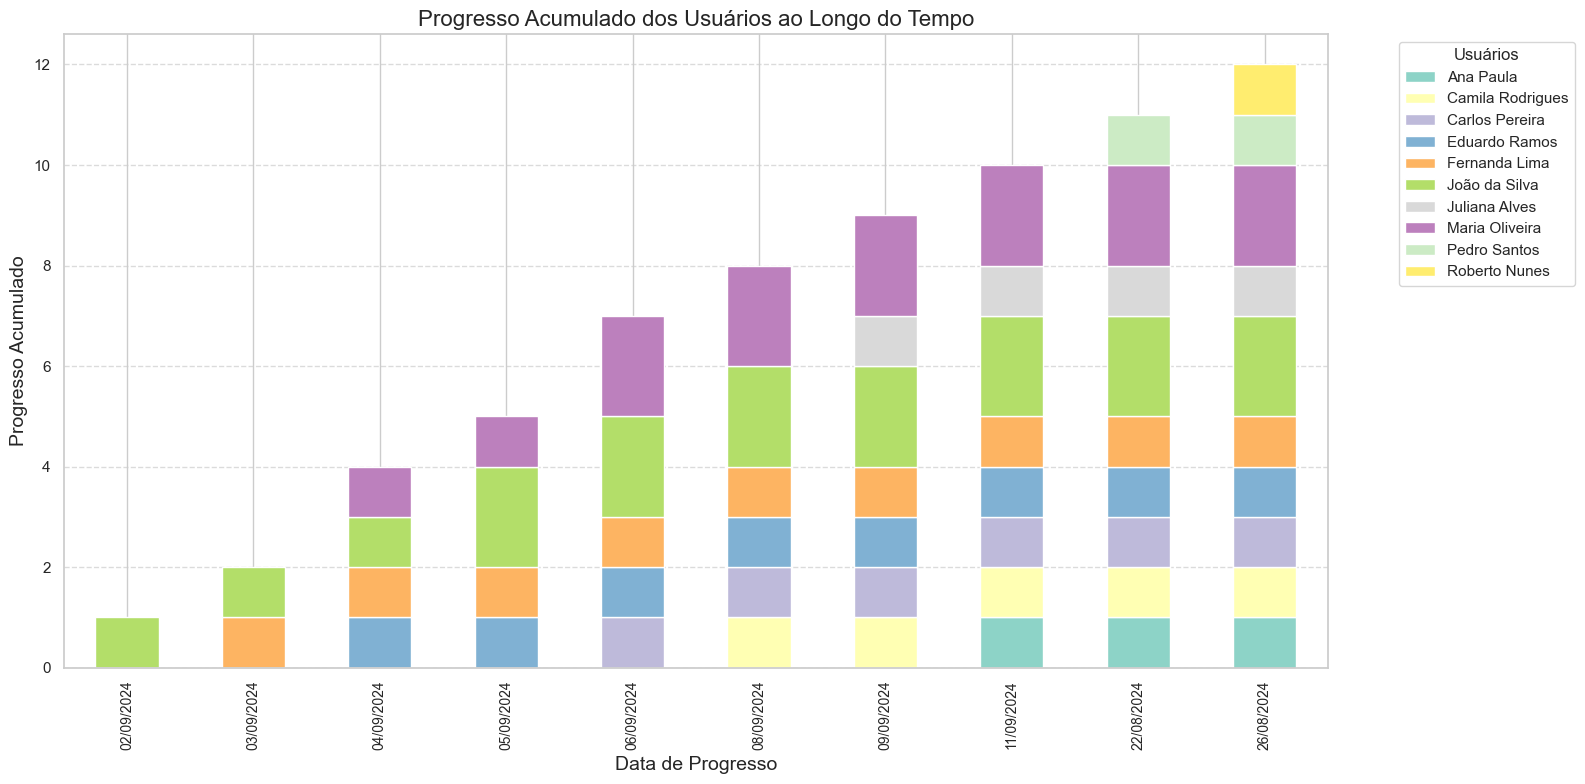

In [7]:
# Formata a coluna 'Data_Progresso' para garantir que está no formato correto
df_progress['Data_Progresso'] = pd.to_datetime(df_progress['Data_Progresso'], errors='coerce').dt.strftime('%d/%m/%Y')

# Agrupa e calcula o progresso acumulado ao longo do tempo
df_progress_grouped = df_progress.groupby(['Data_Progresso', 'Nome']).size().unstack(fill_value=0).cumsum()

# Cria o gráfico de barras empilhadas para o progresso acumulado dos usuários ao longo do tempo
plt.figure(figsize=(16, 8))
df_progress_grouped.plot(kind='bar', stacked=True, colormap='Set3', ax=plt.gca())

# Ajustes de título, eixos e legendas
plt.title('Progresso Acumulado dos Usuários ao Longo do Tempo', fontsize=16)
plt.xlabel('Data de Progresso', fontsize=14)
plt.ylabel('Progresso Acumulado', fontsize=14)
plt.xticks(rotation=90, fontsize=10)

# Coloca a legenda fora do gráfico para não sobrepor
plt.legend(title='Usuários', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Aplica ajustes no layout
plt.tight_layout()
plt.show()



# Consulta SQL para obter o total de finalizações por curso (Popularidade)

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/949910423.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_popularity = pd.read_sql(query_popularity, conn)


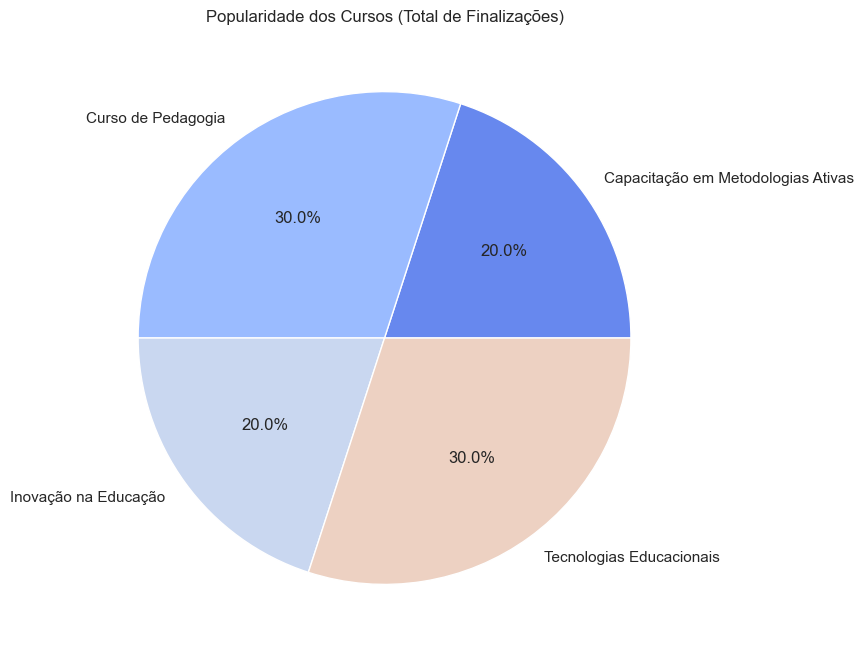

In [8]:
query_popularity = """
SELECT 
    c.name AS Curso, 
    COUNT(DISTINCT e.userId) AS Total_Finalizados
FROM UserProgress up
JOIN Enrollments e ON up.enrollmentId = e.id
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""

df_popularity = pd.read_sql(query_popularity, conn)

plt.figure(figsize=(8,8))
plt.pie(
    df_popularity['Total_Finalizados'], 
    labels=df_popularity['Curso'], 
    autopct='%1.1f%%', 
    colors=sns.color_palette('coolwarm')
)
plt.title('Popularidade dos Cursos (Total de Finalizações)')
plt.show()


# Consulta SQL para obter o progresso individual dos usuários

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/164851370.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_individual_progress = pd.read_sql(query_individual_progress, conn)


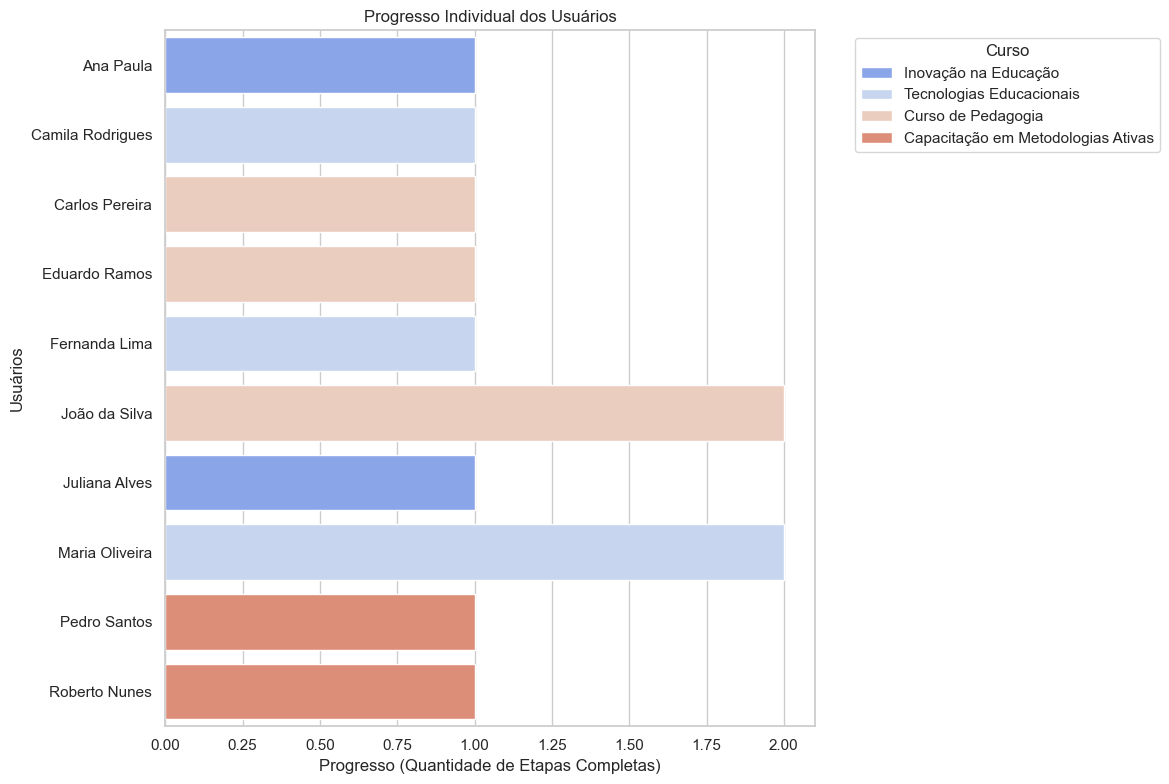

In [9]:
query_individual_progress = """
SELECT 
    u.name AS Nome, 
    c.name AS Curso, 
    COUNT(up.stepId) AS Progresso
FROM UserProgress up
JOIN Enrollments e ON up.enrollmentId = e.id
JOIN Users u ON e.userId = u.id
JOIN Courses c ON e.courseId = c.id
GROUP BY u.name, c.name
ORDER BY u.name, c.name
"""

df_individual_progress = pd.read_sql(query_individual_progress, conn)

plt.figure(figsize=(12,8))
sns.barplot(x='Progresso', y='Nome', hue='Curso', data=df_individual_progress, palette='coolwarm')
plt.title('Progresso Individual dos Usuários')
plt.xlabel('Progresso (Quantidade de Etapas Completas)')
plt.ylabel('Usuários')
plt.legend(title='Curso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# Consulta SQL para obter o desempenho médio por curso

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/923856876.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_benchmarking = pd.read_sql(query_benchmarking, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/923856876.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Media_Desempenho', y='Curso', data=df_benchmarking, palette='viridis')


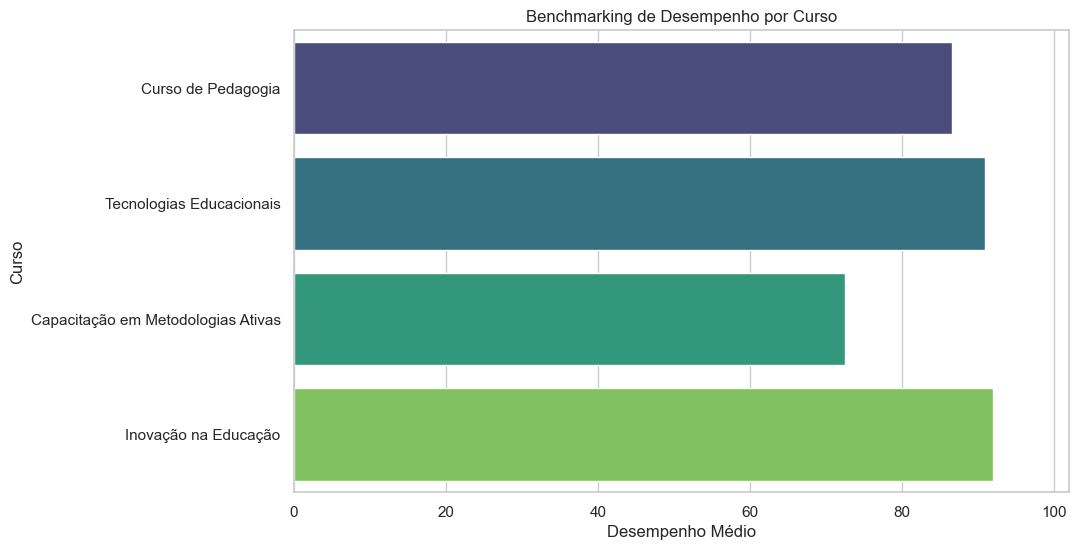

In [10]:
query_benchmarking = """
SELECT c.name AS Curso, AVG(us.score) AS Media_Desempenho
FROM UserScores us
JOIN Enrollments e ON us.userId = e.userId
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""

df_benchmarking = pd.read_sql(query_benchmarking, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='Media_Desempenho', y='Curso', data=df_benchmarking, palette='viridis')
plt.title('Benchmarking de Desempenho por Curso')
plt.xlabel('Desempenho Médio')
plt.ylabel('Curso')
plt.xlim(0, df_benchmarking['Media_Desempenho'].max() + 10)
plt.show()



# Relatório de benchmarking de desempenho

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/1765504362.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_benchmark = pd.read_sql(query, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/1765504362.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Usuario', y='Etapas_Completadas', data=df_benchmark, palette='viridis')


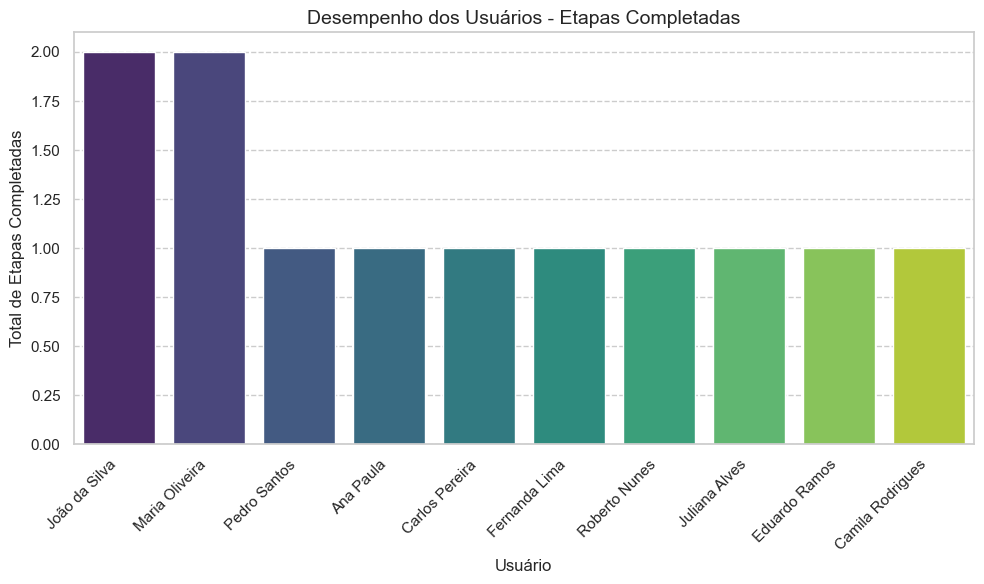

In [11]:
query = """
    SELECT U.name AS Usuario, COUNT(UP.stepId) AS Etapas_Completadas
    FROM Users U
    JOIN Enrollments E ON U.id = E.userId
    JOIN UserProgress UP ON E.id = UP.enrollmentId
    GROUP BY U.name
"""
df_benchmark = pd.read_sql(query, conn)

plt.figure(figsize=(10, 6))
sns.barplot(x='Usuario', y='Etapas_Completadas', data=df_benchmark, palette='viridis')

plt.title('Desempenho dos Usuários - Etapas Completadas', fontsize=14)
plt.xlabel('Usuário', fontsize=12)
plt.ylabel('Total de Etapas Completadas', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--')

plt.tight_layout()
plt.show()


# Gênero dos Usuários

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/2084212425.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_gender = pd.read_sql(query_gender, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/2084212425.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='Total_Usuarios', data=df_gender, palette='coolwarm')


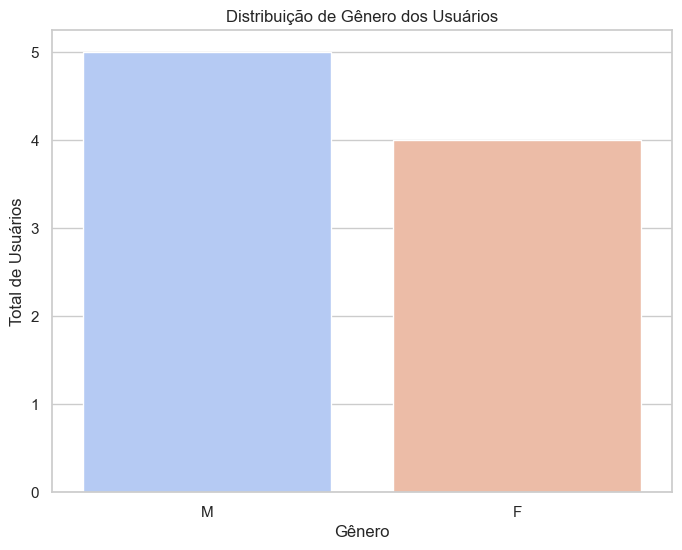

In [12]:
query_gender = """
SELECT gender, COUNT(*) AS Total_Usuarios
FROM Users
GROUP BY gender
"""
df_gender = pd.read_sql(query_gender, conn)

plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='Total_Usuarios', data=df_gender, palette='coolwarm')
plt.title('Distribuição de Gênero dos Usuários')
plt.xlabel('Gênero')
plt.ylabel('Total de Usuários')
plt.show()


# Dashboard de Atividade por Dia da Semana

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/3435495905.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_weekday = pd.read_sql(query_weekday_activity, conn)


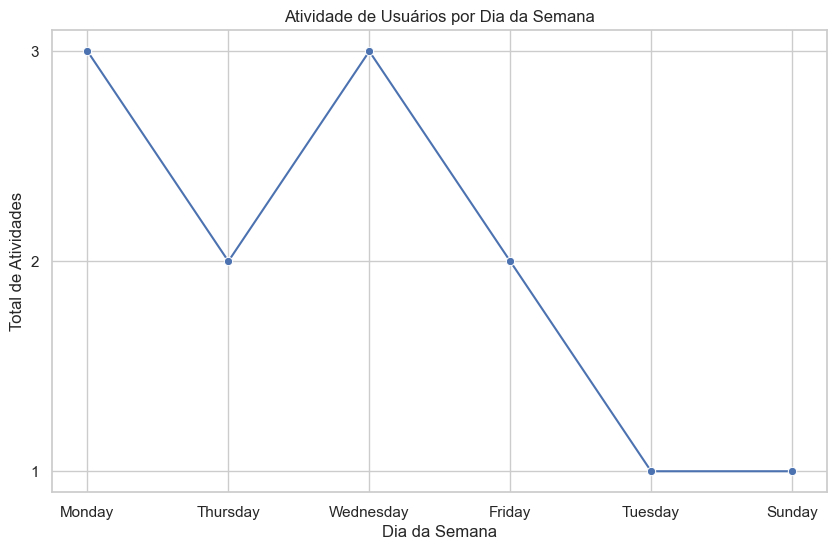

In [13]:
query_weekday_activity = """
SELECT DAYNAME(progressDate) AS Dia_Semana, COUNT(*) AS Total_Atividades
FROM UserProgress
GROUP BY Dia_Semana
ORDER BY FIELD(Dia_Semana, 'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom')
"""
df_weekday = pd.read_sql(query_weekday_activity, conn)

plt.figure(figsize=(10,6))
sns.lineplot(x='Dia_Semana', y='Total_Atividades', data=df_weekday, marker='o', color='b')
plt.title('Atividade de Usuários por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Total de Atividades')
plt.gca().yaxis.get_major_locator().set_params(integer=True)

plt.show()


# Relatório de Taxa de Conclusão de Cursos por Instituição

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/1061032747.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_completion = pd.read_sql(query_course_completion, conn)


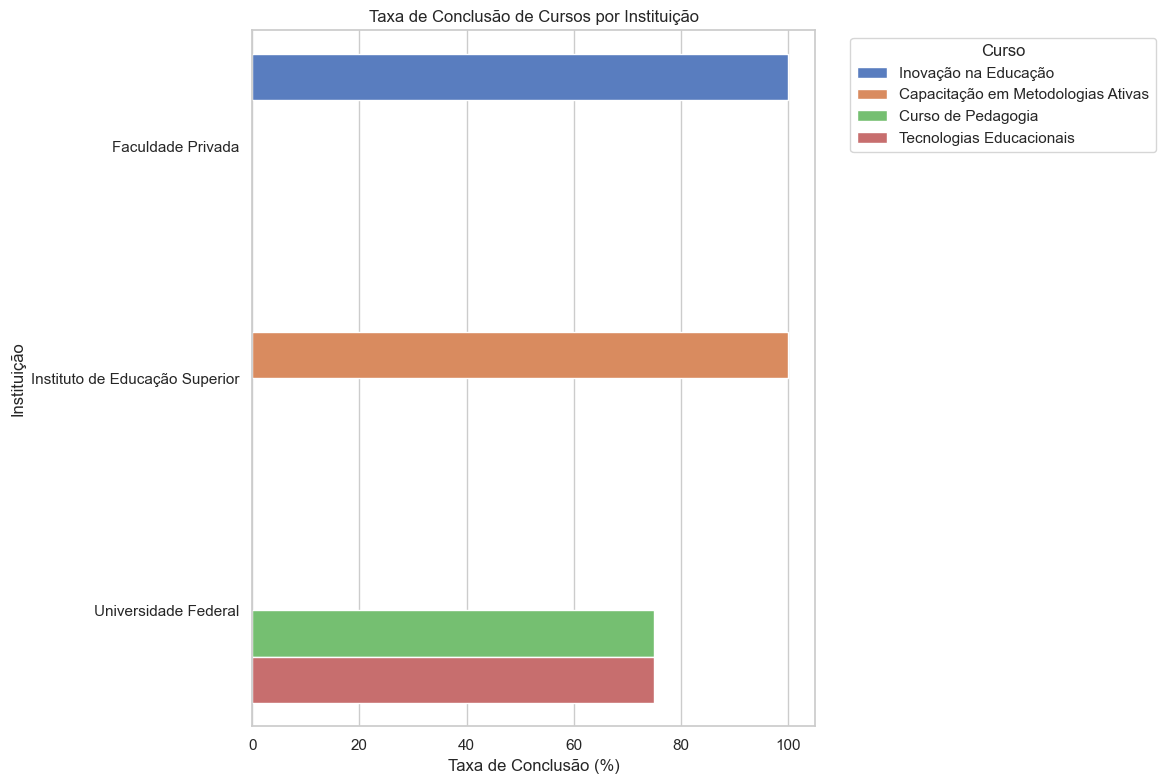

In [14]:
query_course_completion = """
SELECT i.name AS Instituicao, c.name AS Curso, COUNT(e.id) AS Total_Inscritos, 
       COUNT(DISTINCT up.enrollmentId) AS Total_Concluidos
FROM Enrollments e
JOIN Courses c ON e.courseId = c.id
JOIN Institutions i ON c.institutionId = i.id
LEFT JOIN UserProgress up ON e.id = up.enrollmentId
GROUP BY i.name, c.name
"""
df_completion = pd.read_sql(query_course_completion, conn)
df_completion['Taxa_Conclusao'] = (df_completion['Total_Concluidos'] / df_completion['Total_Inscritos']) * 100

plt.figure(figsize=(12,8))
sns.barplot(x='Taxa_Conclusao', y='Instituicao', hue='Curso', data=df_completion, palette='muted')
plt.title('Taxa de Conclusão de Cursos por Instituição')
plt.xlabel('Taxa de Conclusão (%)')
plt.ylabel('Instituição')

# Posicionar a legenda fora do gráfico
plt.legend(title='Curso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Gráfico de Cursos Favoritos

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/555196800.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_favorites = pd.read_sql(query_favorites, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/555196800.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Favoritos', y='Curso', data=df_favorites, palette='coolwarm')


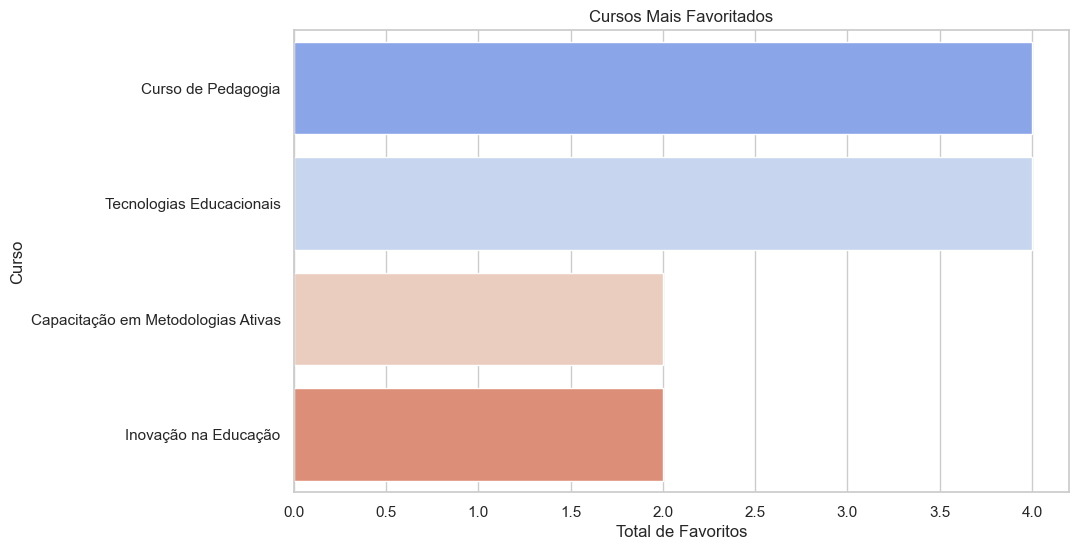

In [15]:
query_favorites = """
SELECT c.name AS Curso, COUNT(fc.userId) AS Total_Favoritos
FROM FavoritedCourses fc
JOIN Courses c ON fc.courseId = c.id
GROUP BY c.name
"""
df_favorites = pd.read_sql(query_favorites, conn)

plt.figure(figsize=(10,6))
sns.barplot(x='Total_Favoritos', y='Curso', data=df_favorites, palette='coolwarm')
plt.title('Cursos Mais Favoritados')
plt.xlabel('Total de Favoritos')
plt.ylabel('Curso')
plt.show()


# Análise de Etapas Não Completas

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_52752/2910293635.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_incomplete_steps = pd.read_sql(query_incomplete_steps, conn)


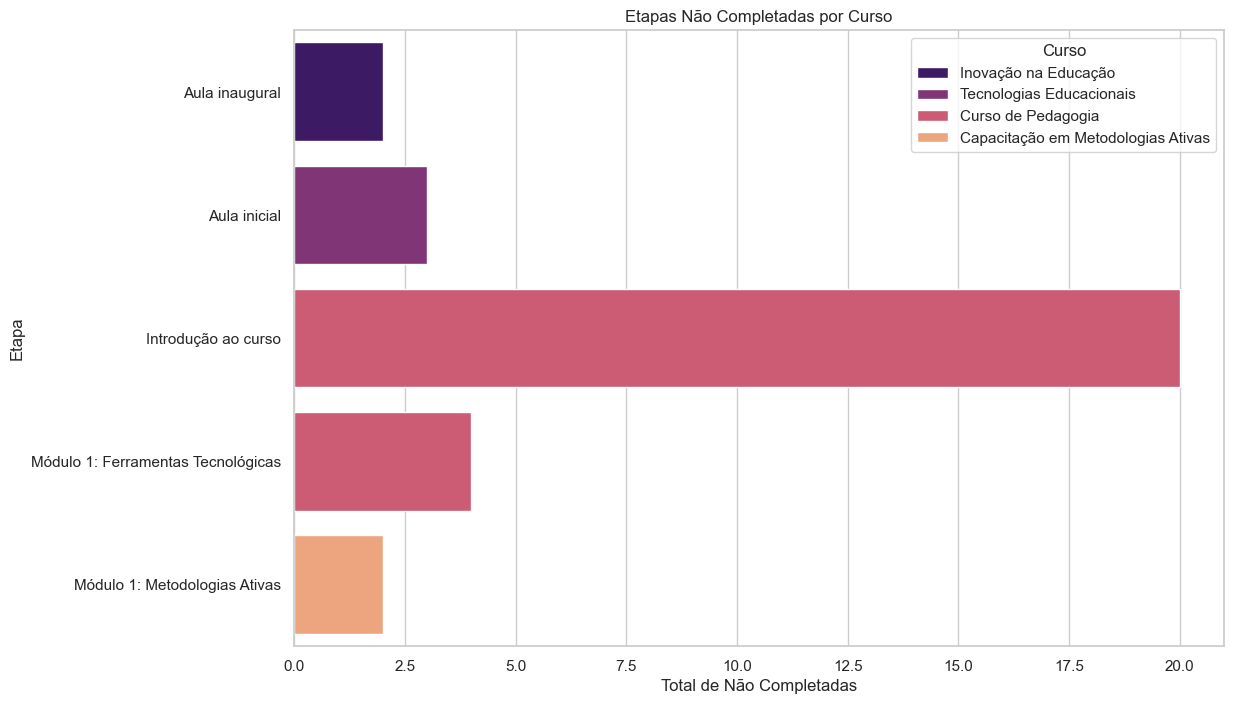

In [18]:
query_incomplete_steps = """
SELECT s.title AS Etapa, c.name AS Curso, 
       (COUNT(e.id) - COUNT(DISTINCT up.enrollmentId)) AS Total_Nao_Completas
FROM Steps s
JOIN Courses c ON s.courseId = c.id
LEFT JOIN UserProgress up ON s.id = up.stepId
LEFT JOIN Enrollments e ON e.courseId = s.courseId
GROUP BY s.title, c.name
"""
df_incomplete_steps = pd.read_sql(query_incomplete_steps, conn)

plt.figure(figsize=(12,8))
sns.barplot(x='Total_Nao_Completas', y='Etapa', hue='Curso', data=df_incomplete_steps, palette='magma')
plt.title('Etapas Não Completadas por Curso')
plt.xlabel('Total de Não Completadas')
plt.ylabel('Etapa')
plt.show()


# Dashboard de Desempenho em Atividades Avaliativas

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_53425/2908469829.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_activity_perf = pd.read_sql(query_activity_performance, conn)


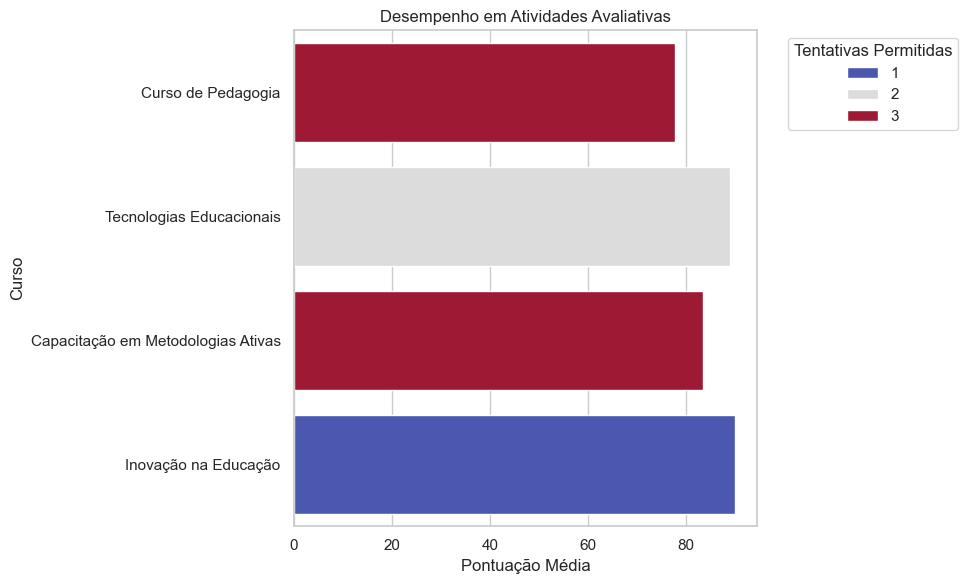

In [9]:
query_activity_performance = """
SELECT c.name AS Curso, a.allowedAttempts AS Tentativas_Permitidas, 
       AVG(at.score) AS Media_Pontuacao, COUNT(at.id) AS Total_Tentativas
FROM Activities a
JOIN ActivityAttempts at ON a.id = at.activityId
JOIN Courses c ON a.stepId = c.id
GROUP BY c.name, a.allowedAttempts
"""
df_activity_perf = pd.read_sql(query_activity_performance, conn)

plt.figure(figsize=(10,6))
sns.barplot(x='Media_Pontuacao', y='Curso', hue='Tentativas_Permitidas', data=df_activity_perf, palette='coolwarm')
plt.title('Desempenho em Atividades Avaliativas')
plt.xlabel('Pontuação Média')
plt.ylabel('Curso')


plt.legend(title='Tentativas Permitidas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Análise Temporal de Conquista de “Cards

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_53425/1030776891.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cards = pd.read_sql(query_cards_acquired, conn)


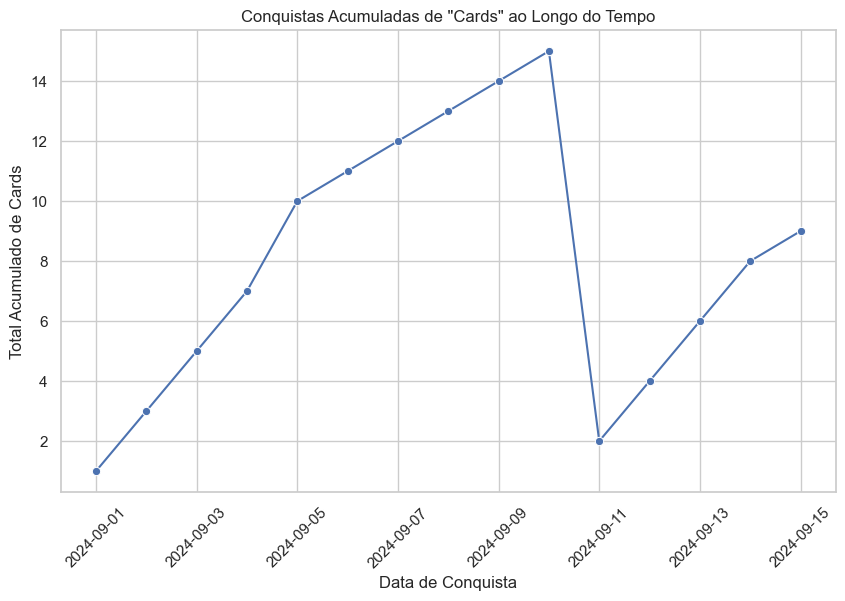

In [34]:
query_cards_acquired = """
SELECT DATE(uc.acquirement_date) AS Data_Conquista, COUNT(*) AS Total_Cards
FROM UserCards uc
GROUP BY DATE(uc.acquirement_date)
"""
df_cards = pd.read_sql(query_cards_acquired, conn)

# Calcular o total acumulado
df_cards['Total_Cards_Acumulado'] = df_cards['Total_Cards'].cumsum()

plt.figure(figsize=(10,6))
sns.lineplot(x='Data_Conquista', y='Total_Cards_Acumulado', data=df_cards, marker='o')
plt.title('Conquistas Acumuladas de "Cards" ao Longo do Tempo')
plt.xlabel('Data de Conquista')
plt.ylabel('Total Acumulado de Cards')
plt.xticks(rotation=45)
plt.show()


# Taxa de Atividades Completadas Dentro do Prazo

/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_53425/2686441187.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_on_time = pd.read_sql(query_on_time, conn)
/var/folders/9r/7yls0v3x7dn8j9zhfncqkj800000gp/T/ipykernel_53425/2686441187.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Taxa_Dentro_Prazo', y='Curso', data=df_on_time, palette='mako')


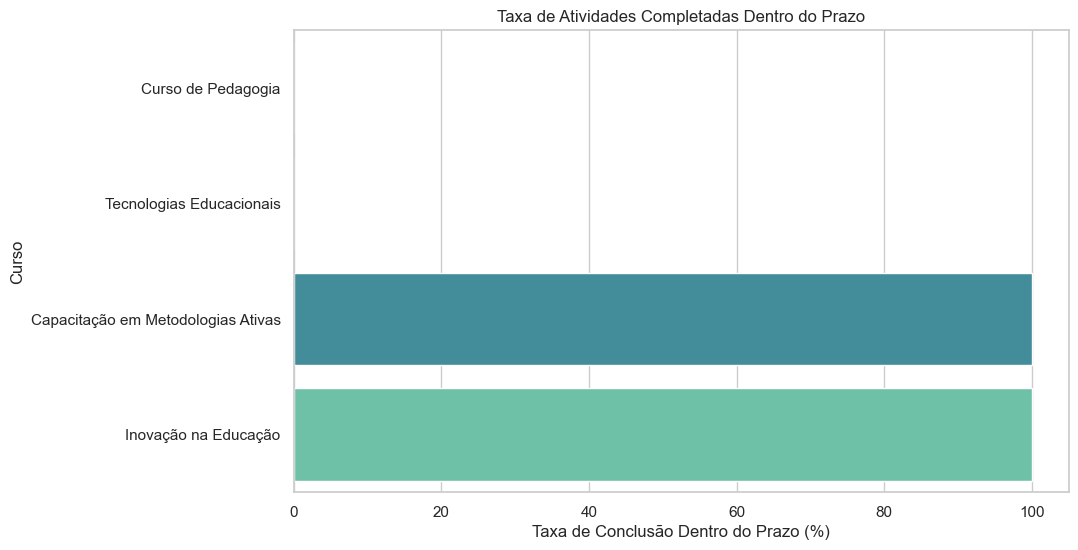

In [31]:
query_on_time = """
SELECT c.name AS Curso, 
       COUNT(CASE WHEN up.progressDate <= DATE_ADD(e.enrollmentDate, INTERVAL c.requiredTimeLimit DAY) THEN 1 END) AS Dentro_Prazo,
       COUNT(*) AS Total_Atividades
FROM UserProgress up
JOIN Enrollments e ON up.enrollmentId = e.id
JOIN Courses c ON e.courseId = c.id
GROUP BY c.name
"""
df_on_time = pd.read_sql(query_on_time, conn)
df_on_time['Taxa_Dentro_Prazo'] = (df_on_time['Dentro_Prazo'] / df_on_time['Total_Atividades']) * 100

plt.figure(figsize=(10,6))
sns.barplot(x='Taxa_Dentro_Prazo', y='Curso', data=df_on_time, palette='mako')
plt.title('Taxa de Atividades Completadas Dentro do Prazo')
plt.xlabel('Taxa de Conclusão Dentro do Prazo (%)')
plt.ylabel('Curso')
plt.show()


In [16]:
df_benchmark.to_csv('relatorio_benchmark.csv', index=False, encoding='utf-8-sig')
print("Relatório exportado com sucesso como CSV.")


Relatório exportado com sucesso como CSV.


In [17]:
df_benchmark.to_excel('relatorio_benchmark.xlsx', index=False, engine='openpyxl')
print("Relatório exportado com sucesso como Excel.")


Relatório exportado com sucesso como Excel.


In [12]:
conn.close()